In [10]:
# movie theatre simulation

In [1]:
import simpy as smp
import random
import statistics

In [13]:
wait_times = []

In [34]:
env = smp.Environment()

In [35]:
def car(env):
    while True:
        print('Start parking at %d' % env.now)
        parking_duration = 5
        yield env.timeout(parking_duration)
        print('Done parking at %d' % env.now)
        
        print('Start driving at %d' % env.now)
        trip_duration = 2
        yield env.timeout(trip_duration)
        print('Done parking at %d' % env.now)

In [36]:
env.process(car(env))

<Process(car) object at 0x10351ad90>

In [37]:
env.run(until=20)

Start parking at 0
Done parking at 5
Start driving at 5
Done parking at 7
Start parking at 7
Done parking at 12
Start driving at 12
Done parking at 14
Start parking at 14
Done parking at 19
Start driving at 19


In [29]:
env.now

15

In [38]:
class Car(object):
    def __init__(self, env):
        self.env = env
        # Start the run process everytime an instance is created.
        self.action = env.process(self.run())

    def run(self):
        while True:
            print('Start parking and charging at %d' % self.env.now)
            charge_duration = 5
            # We yield the process that process() returns
            # to wait for it to finish
            yield self.env.process(self.charge(charge_duration))

            # The charge process has finished and
            # we can start driving again.
            print('Start driving at %d' % self.env.now)
            trip_duration = 2
            yield self.env.timeout(trip_duration)

    def charge(self, duration):
        yield self.env.timeout(duration)

In [40]:
env2 = simpy.Environment()
car = Car(env2)
env2.run(until=15)

Start parking and charging at 0
Start driving at 5
Start parking and charging at 7
Start driving at 12
Start parking and charging at 14


# Interrupting a running car

In [64]:
class Car(object):
    def __init__(self, env):
        self.env = env
        self.action = env.process(self.run1())

    def run1(self):
        while True:
            print('Start parking and charging at %d' % self.env.now)
            charge_duration = 5
            # We may get interrupted while charging the battery
            try:
                yield self.env.process(self.charge(charge_duration))
            except simpy.Interrupt:
                # When we received an interrupt, we stop charging and
                # switch to the "driving" state
                print('Was interrupted. Hope, the battery is full enough ...')

            print('Start driving at %d' % self.env.now)
            trip_duration = 2
            yield self.env.timeout(trip_duration)

    def charge(self, duration):
        yield self.env.timeout(duration)


In [65]:
def driver(env, car):
    yield env.timeout(3)
    print('Going to interrupt')
    car.action.interrupt()

In [66]:
env = simpy.Environment()
car = Car(env)
env.process(driver(env, car))
env.run(until=15)

Start parking and charging at 0
Going to interrupt
Was interrupted. Hope, the battery is full enough ...
Start driving at 3
Start parking and charging at 5
Start driving at 10
Start parking and charging at 12


# Shared resources

In [71]:
def car(env, name, bcs, driving_time, charge_duration):
    # Simulate driving to the BCS
    yield env.timeout(driving_time)

    # Request one of its charging spots
    print('%s arriving at %d' % (name, env.now))
    with bcs.request() as req:
        yield req

        # Charge the battery
        print('%s starting to charge at %s' % (name, env.now))
        yield env.timeout(charge_duration)
        print('%s leaving the bcs at %s' % (name, env.now))

In [84]:
env3 = simpy.Environment()
bcs = simpy.Resource(env3, capacity=2) #creating two resources i-e charging station

In [85]:
for i in range(4):
    env3.process(car(env3, 'Car %d' % i, bcs, i*2, 5))

In [86]:
env3.run()

Car 0 arriving at 0
Car 0 starting to charge at 0
Car 1 arriving at 2
Car 1 starting to charge at 2
Car 2 arriving at 4
Car 0 leaving the bcs at 5
Car 2 starting to charge at 5
Car 3 arriving at 6
Car 1 leaving the bcs at 7
Car 3 starting to charge at 7
Car 2 leaving the bcs at 10
Car 3 leaving the bcs at 12


# Basics

In [87]:
def example(env):
    value = yield env.timeout(1, value=42)
    print('now=%d, value=%d' % (env.now, value))

env = smp.Environment()
p = env.process(example(env))
env.run()

now=1, value=42


In [91]:
def example2(env):
    value = yield env.timeout(1, value=42)
    print('now=%d, value=%d' % (env.now, value))

In [90]:
env.process(example(env))
env.run()

now=3, value=42


In [92]:
env.process(example2(env))
env.run()

now=4, value=42


# Environments

In [107]:
env6 = smp.Environment()

In [108]:
for i in range(100):
    env6.run(until=i+8)
    print(env6.now)

8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


Instead of passing a number to run(), you can also pass any event to it. run() will then return when the event has been processed.

In [116]:
def my_proc(env):
    yield env.timeout(1)
    print(env.peek())
    yield env.timeout(10)
    return 'Monty pythons circus'

In [117]:
env = smp.Environment()
proc = env.process(my_proc(env))
env.run(until=proc)

inf


'Monty pythons circus'

In [118]:
env.now

11

In [114]:
until = 10
while env.peek() < until:
   env.step()

In [119]:
def subfunc(env):
    print(env.active_process)

def my_proc(env):
    while True:
        print(env.active_process)  # will print "p1"
        subfunc(env)
        yield env.timeout(1)

In [122]:
env = simpy.Environment()
p1 = env.process(my_proc(env))
print(env.active_process)
env.step()
print(env.active_process)

None
<Process(my_proc) object at 0x103d76510>
<Process(my_proc) object at 0x103d76510>
None


In [128]:
def my_callback(event):
    print('Called back from', event)

In [129]:
env = smp.Environment()
event = env.event()
event.callbacks.append(my_callback)
event.callbacks

[<function __main__.my_callback(event)>]

# Usages of events

In [131]:
class School:
    def __init__(self, env):
        self.env = env
        self.class_ends = env.event()
        self.pupil_procs = [env.process(self.pupil()) for i in range(3)]
        self.bell_proc = env.process(self.bell())

    def bell(self):
        for i in range(2):
            yield self.env.timeout(45)
            self.class_ends.succeed()
            self.class_ends = self.env.event()
            print()

    def pupil(self):
        for i in range(2):
            print(r' \o/', end='')
            yield self.class_ends

In [132]:
school = School(env)
env.run()

 \o/ \o/ \o/
 \o/ \o/ \o/


# Processes are events too

In [133]:
def sub(env):
    yield env.timeout(1)
    return 23

In [134]:
def parent(env):
    ret = yield env.process(sub(env))
    return ret

In [135]:
env.run(env.process(parent(env)))

23

## start a process after some delay

In [136]:
from simpy.util import start_delayed

def sub(env):
    yield env.timeout(1)
    return 23

def parent(env):
    sub_proc = yield start_delayed(env, sub(env), delay=3)
    ret = yield sub_proc
    return ret

In [137]:
env.run(env.process(parent(env)))

23

# Algo.

In [149]:
import simpy as smp
import random
import statistics
import numpy as np
import pandas as pd
import operator

In [150]:
#arr_rate_mean = [20,30,40]

# Simulating environment

In [151]:
def get_time_stamps(num_slices, quantum):
    time_stamps = random.sample(range(1, quantum), num_slices)
    return time_stamps

In [152]:
def get_value(mu, sigma):
    return np.random.normal(mu, sigma, 1)[0]

In [153]:
def generate_a_slice(class_type, time):
    a_slice = dict()
    # generate bid_value
    bid_value = np.floor(get_value(slice_req_params[class_type]['mean_bid_val'],
                          slice_req_params[class_type]['var']))
    
    # generate slice_duration
    slice_duration = np.floor(get_value(slice_req_params[class_type]['mean_duration'],
                          slice_req_params[class_type]['var']))

    # generate SLAV neglected
    SLAV_permit = slice_req_params[class_type]['SLAV']

    # generate cpu request
    ncpu = np.floor(get_value(slice_class_res_req[class_type]['NC'],
                     slice_req_params[class_type]['var']))

    # generate bw request
    nbw = np.floor(get_value(slice_class_res_req[class_type]['NB'],
                     slice_req_params[class_type]['var']))

    # generate memory request
    nm = np.floor(get_value(slice_class_res_req[class_type]['NM'],
                     slice_req_params[class_type]['var']))

    a_slice['bid_value']= bid_value
    a_slice['slice_duration']= slice_duration
    a_slice['SLAV_permit']= SLAV_permit
    a_slice['ncpu']= ncpu
    a_slice['nbw']= nbw
    a_slice['nm']= nm
    a_slice['class']= class_type
    a_slice['time']= time
    a_slice['end_time']= time + slice_duration

    return a_slice

In [154]:
def get_slices(class_type, quantum, curr_time):

    num_slices = int(max(1, np.floor(get_value(slice_req_params[class_type]['arr_rate_mean'], slice_req_params[class_type]['var']))))
    time_stamps = get_time_stamps(num_slices, quantum)
    time_stamps = list(map(lambda x: x + curr_time, time_stamps))
    time_stamps.sort()
    slices = [generate_a_slice(class_type, time_stamps[i]) for i in range(int(num_slices))]
    # print(len(time_stamps),' of ', class_type)
    return slices

# Decision algos.

In [155]:
existing_slices = list()

In [156]:
def release_slice(slice_, current_time):
    
    if slice_['end_time']<current_time:
        return 1
    else:
        return 0

In [157]:
def release_slices(active_slices, curr_time):
    expired_slices_count = 0
    for slice_ in active_slices:
        if int(slice_['end_time'])<curr_time:
            total_res['C'] += slice_['ncpu']
            total_res['M'] += slice_['nm']
            total_res['B'] += slice_['nbw']
            active_slices.remove(slice_)
            expired_slices_count+=1
    return active_slices, expired_slices_count

In [158]:
def generate_slav_for_c1():
    num = np.random.exponential(3.45)
    if num>15:
        return 1

In [159]:
def generate_slav_for_c2():
    num = random.uniform(0, 1)
    if num > 0.9:
        return 1

In [160]:
def generate_slav_for_c3():
    num = random.uniform(0, 1)
    if num > 0.95:
        return 1

In [161]:
def calculate_revenue(active_slices):
    # calculate revenue
    active_revenue = 0
    for slice_ in active_slices:
        active_revenue += slice_['bid_value']
    return active_revenue

In [162]:
def calculate_slav(active_slices):
    slav = 0
    
    for slice_ in active_slices:
        if slice_['class']=='C1':
            val = generate_slav_for_c1()
            if val:
                slav+=slice_req_params['C1']['slav_penalty']
        elif slice_['class']=='C2':
            val = generate_slav_for_c2()
            if val:
                slav+=slice_req_params['C2']['slav_penalty']
        else:
            val = generate_slav_for_c3()
            if val:
                slav+=slice_req_params['C3']['slav_penalty']
                
    return slav

## 1. Simple fcfs algo.

In [163]:
def simple(slice_reqs):
    
    rej_penalty = 0
    accepted_slices = list()
    # assigning resources on fcfs basis
    for slice_ in slice_reqs:
        s_cpu = slice_['ncpu']
        s_m = slice_['nm']
        s_bw = slice_['nbw']
        
        if total_res['C'] >= s_cpu and total_res['M']>= s_m and total_res['B']>=s_bw:
            total_res['C'] -= s_cpu
            total_res['M'] -= s_m
            total_res['B'] -= s_bw
            accepted_slices.append(slice_)
        else:
            rej_penalty += slice_req_params[slice_['class']]['rej_penalty']
            continue

    return accepted_slices, rej_penalty

## 2. Heirarchical PPO algo.

In [164]:
import os

In [165]:
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
print(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

/Users/sailor_omkar/Codes/HMARL_exp/src


In [168]:
from stable_baselines3 import A2C, PPO, DQN
from envs.hmarl_central_env import CentralAgentEnv
from envs.hmarl_slice_env import ElasticSliceAgentEnv

In [169]:
slice_agent_env_c1 = ElasticSliceAgentEnv(slice_class = 'C1')
slice_agent_env_c2 = ElasticSliceAgentEnv(slice_class = 'C2')
slice_agent_env_c3 = ElasticSliceAgentEnv(slice_class = 'C3')
central_agent_env = CentralAgentEnv()

In [170]:
model_folder_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'hmarl2', 'selected_models'))
    
                                        
# loading models
ppo_central_model = PPO.load(os.path.abspath(os.path.join(model_folder_path, 'central_PPO', '1800000.zip')), central_agent_env)

ppo_model_dict = {
    'C1': PPO.load(os.path.abspath(os.path.join(model_folder_path, 'PPO_C1', '2700000.zip')), slice_agent_env_c1),
    'C2': PPO.load(os.path.abspath(os.path.join(model_folder_path, 'PPO_C2', '1900000.zip')), slice_agent_env_c2),
    'C3': PPO.load(os.path.abspath(os.path.join(model_folder_path, 'PPO_C3', '1800000.zip')), slice_agent_env_c3),
}

dqn_central_model = DQN.load(os.path.abspath(os.path.join(model_folder_path, 'central_DQN', '1400000.zip')), central_agent_env)

dqn_model_dict = {
    'C1': DQN.load(os.path.abspath(os.path.join(model_folder_path, 'DQN_C1', '1400000.zip')), slice_agent_env_c1),
    'C2': DQN.load(os.path.abspath(os.path.join(model_folder_path, 'DQN_C2', '1400000.zip')), slice_agent_env_c2),
    'C3': DQN.load(os.path.abspath(os.path.join(model_folder_path, 'DQN_C3', '1400000.zip')), slice_agent_env_c3),
}

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [171]:
def s_ppo(slice_reqs):
    rej_penalty = 0
    accepted_slices = list()
    
    class_dict = {"C1": 0, "C2": 1, "C3": 2}
    # assigning resources on hmarl basis
    for slice_ in slice_reqs:
        s_cpu = slice_['ncpu']
        s_m = slice_['nm']
        s_bw = slice_['nbw']
        s_class = slice_['class']
        s_duration = slice_['slice_duration']
        s_bid = slice_['bid_value']
        
        
        if total_res['C'] >= s_cpu and total_res['M']>= s_m and total_res['B']>=s_bw:
            
            central_action, _ = ppo_central_model.predict(
                                {'av_cpu': np.array([total_res['C']]),
                                 'av_mem': np.array([total_res['M']]),
                                 'av_bw': np.array([total_res['B']]),
                                 'req_cpu': np.array([s_cpu]),
                                 'req_bw': np.array([s_bw]),
                                 'req_mem': np.array([s_m]),
                                 'duration': np.array([s_duration]),
                                 'bid_value': np.array([s_bid]),
                                 'slice_class': np.array([class_dict[s_class]])})
                
            if central_action:
                total_res['C'] -= s_cpu
                total_res['M'] -= s_m
                total_res['B'] -= s_bw
                accepted_slices.append(slice_)
            else:
                rej_penalty += slice_req_params[slice_['class']]['rej_penalty']
        else:
            rej_penalty += slice_req_params[slice_['class']]['rej_penalty']
            continue

    return accepted_slices, rej_penalty

In [172]:
def s_dqn(slice_reqs):
    rej_penalty = 0
    accepted_slices = list()
    
    class_dict = {"C1": 0, "C2": 1, "C3": 2}
    # assigning resources on hmarl basis
    for slice_ in slice_reqs:
        s_cpu = slice_['ncpu']
        s_m = slice_['nm']
        s_bw = slice_['nbw']
        s_class = slice_['class']
        s_duration = slice_['slice_duration']
        s_bid = slice_['bid_value']
        
        
        if total_res['C'] >= s_cpu and total_res['M']>= s_m and total_res['B']>=s_bw:
            central_action, _ = dqn_central_model.predict(
                                {'av_cpu': np.array([total_res['C']]),
                                 'av_mem': np.array([total_res['M']]),
                                 'av_bw': np.array([total_res['B']]),
                                 'req_cpu': np.array([s_cpu]),
                                 'req_bw': np.array([s_bw]),
                                 'req_mem': np.array([s_m]),
                                 'duration': np.array([s_duration]),
                                 'bid_value': np.array([s_bid]),
                                 'slice_class': np.array([class_dict[s_class]])})

            if central_action:
                total_res['C'] -= s_cpu
                total_res['M'] -= s_m
                total_res['B'] -= s_bw
                accepted_slices.append(slice_)
            else:
                rej_penalty += slice_req_params[slice_['class']]['rej_penalty']
        else:
            rej_penalty += slice_req_params[slice_['class']]['rej_penalty']
            continue

    return accepted_slices, rej_penalty

In [173]:
def h_ppo(slice_reqs):
    rej_penalty = 0
    accepted_slices = list()
    
    class_dict = {"C1": 0, "C2": 1, "C3": 2}
    # assigning resources on hmarl basis
    for slice_ in slice_reqs:
        s_cpu = slice_['ncpu']
        s_m = slice_['nm']
        s_bw = slice_['nbw']
        s_class = slice_['class']
        s_duration = slice_['slice_duration']
        s_bid = slice_['bid_value']
        
        
        if total_res['C'] >= s_cpu and total_res['M']>= s_m and total_res['B']>=s_bw:
            # taking decision of class level agents.
            agent_action, _ = ppo_model_dict[s_class].predict(
                                    {'av_cpu': np.array([total_res['C']]),
                                     'av_mem': np.array([total_res['M']]),
                                     'av_bw': np.array([total_res['B']]),
                                     'req_cpu': np.array([s_cpu]),
                                     'req_bw': np.array([s_bw]),
                                     'req_mem': np.array([s_m]),
                                     'duration': np.array([s_duration]),
                                     'bid_value': np.array([s_bid])})
            
            # taking decision of central agents.
            if agent_action:
                central_action, _ = ppo_central_model.predict(
                                    {'av_cpu': np.array([total_res['C']]),
                                     'av_mem': np.array([total_res['M']]),
                                     'av_bw': np.array([total_res['B']]),
                                     'req_cpu': np.array([s_cpu]),
                                     'req_bw': np.array([s_bw]),
                                     'req_mem': np.array([s_m]),
                                     'duration': np.array([s_duration]),
                                     'bid_value': np.array([s_bid]),
                                     'slice_class': np.array([class_dict[s_class]])})
                
                if central_action:
                    total_res['C'] -= s_cpu
                    total_res['M'] -= s_m
                    total_res['B'] -= s_bw
                    accepted_slices.append(slice_)
                else:
                    rej_penalty += slice_req_params[slice_['class']]['rej_penalty']
        else:
            rej_penalty += slice_req_params[slice_['class']]['rej_penalty']
            continue

    return accepted_slices, rej_penalty

In [174]:
def h_dqn(slice_reqs):
    rej_penalty = 0
    accepted_slices = list()
    
    class_dict = {"C1": 0, "C2": 1, "C3": 2}
    # assigning resources on hmarl basis
    for slice_ in slice_reqs:
        s_cpu = slice_['ncpu']
        s_m = slice_['nm']
        s_bw = slice_['nbw']
        s_class = slice_['class']
        s_duration = slice_['slice_duration']
        s_bid = slice_['bid_value']
        
        
        if total_res['C'] >= s_cpu and total_res['M']>= s_m and total_res['B']>=s_bw:
            # taking decision of class level agents.
            agent_action, _ = dqn_model_dict[s_class].predict(
                                    {'av_cpu': np.array([total_res['C']]),
                                     'av_mem': np.array([total_res['M']]),
                                     'av_bw': np.array([total_res['B']]),
                                     'req_cpu': np.array([s_cpu]),
                                     'req_bw': np.array([s_bw]),
                                     'req_mem': np.array([s_m]),
                                     'duration': np.array([s_duration]),
                                     'bid_value': np.array([s_bid])})
            
            # taking decision of central agents.
            if agent_action:
                central_action, _ = dqn_central_model.predict(
                                    {'av_cpu': np.array([total_res['C']]),
                                     'av_mem': np.array([total_res['M']]),
                                     'av_bw': np.array([total_res['B']]),
                                     'req_cpu': np.array([s_cpu]),
                                     'req_bw': np.array([s_bw]),
                                     'req_mem': np.array([s_m]),
                                     'duration': np.array([s_duration]),
                                     'bid_value': np.array([s_bid]),
                                     'slice_class': np.array([class_dict[s_class]])})
                
                if central_action:
                    total_res['C'] -= s_cpu
                    total_res['M'] -= s_m
                    total_res['B'] -= s_bw
                    accepted_slices.append(slice_)
                else:
                    rej_penalty += slice_req_params[slice_['class']]['rej_penalty']
        else:
            rej_penalty += slice_req_params[slice_['class']]['rej_penalty']
            continue

    return accepted_slices, rej_penalty

# Network window simulation

In [175]:
def a_net_win(env, NW, quantum, algo):
    # get slices distributed till time t
    slice_list = list()
    active_slices = list()
    revenue = 0
    quantum_count = 0
    slav_penalty = 0
    
    while env.now < NW:
        
        # get slices which are well distributed in interval t
        new_slices = list()
        for class_ in class_types:
            new_slices.extend(get_slices(class_, quantum, env.now))
        
        
        new_slices.sort(key = operator.itemgetter('time'))
        # print(new_slices)
        # df = pd.DataFrame(new_slices)
        # df.to_excel('output.xlsx')
        
        # releasing resources
        active_slices, expired_slices_count = release_slices(active_slices, env.now)
        
        # select slices
        if algo == 'simple':
            accepted_slices, rej_penalty = simple(new_slices)
        elif algo == 'heirar_PPO':
            accepted_slices, rej_penalty = h_ppo(new_slices)
        elif algo == 'heirar_DQN':
            accepted_slices, rej_penalty = h_dqn(new_slices)
        elif algo == 'simple_PPO':
            accepted_slices, rej_penalty = s_ppo(new_slices)
        elif algo == 'simple_DQN':
            accepted_slices, rej_penalty = s_dqn(new_slices)
            
        active_slices.extend(accepted_slices)
        
        # compute SLAV
        slav_penalty = calculate_slav(active_slices)
        
        # compute revenue
        curr_revenue = calculate_revenue(active_slices) - slav_penalty - rej_penalty
        revenue+= curr_revenue
        
        quantum_count +=1
        yield env.timeout(quantum)
        
    print(f'Total Revenue {algo}', revenue) 
        
    return slice_list, revenue

In [176]:
slice_req_params = {
    'C1':{'NC':4000, 'NB':1100, 'NM':2000, 'arr_rate_mean': 7, 'mean_bid_val': 25, 'var':1, 'mean_duration':90, 'SLAV':0, 'rej_penalty':100, 'slav_penalty':25},
    'C2':{'NC':2000, 'NB':500, 'NM':1500, 'arr_rate_mean': 9, 'mean_bid_val': 15, 'var':1.5, 'mean_duration':70,'SLAV':5, 'rej_penalty':0, 'slav_penalty':15},
    'C3':{'NC':1500, 'NB':300, 'NM':1000, 'arr_rate_mean': 12, 'mean_bid_val': 12, 'var':1.8, 'mean_duration':30,'SLAV':10, 'rej_penalty':0, 'slav_penalty':10}               
}

slice_class_res_req = {
    'C1':{'NC':4000, 'NB':1100, 'NM':2000},
    'C2':{'NC':2000, 'NB':500, 'NM':1500},
    'C3':{'NC':1500, 'NB':300, 'NM':1000}
}

total_res = {
    'C': 100000,
    'B': 70000,
    'M': 100000
}

class_types = ['C1', 'C2', 'C3']
quantum = 60
# NW = 400
# algo = 'heirar_PPO'

In [177]:
algo_revenues = {'simple': [], 'heirar_PPO': [], 'heirar_DQN': [], 'simple_PPO': [], 'simple_DQN':[]}

def first_process(env, NW, quantum, algo):
    return_value, revenue = yield env.process(a_net_win(env, NW, quantum, algo))
    algo_revenues[algo].append(revenue)
    
for algo in ['simple', 'heirar_PPO', 'heirar_DQN', 'simple_PPO', 'simple_DQN']:
    for NW in [ 2000, 4000, 6000, 8000, 10000, 12000, 15000, 18000, 20000]:
        
        slice_req_params = {
            'C1':{'NC':4000, 'NB':1100, 'NM':2000, 'arr_rate_mean': 7, 'mean_bid_val': 25, 'var':1, 'mean_duration':90, 'SLAV':0, 'rej_penalty':100, 'slav_penalty':25},
            'C2':{'NC':2000, 'NB':500, 'NM':1500, 'arr_rate_mean': 9, 'mean_bid_val': 15, 'var':1.5, 'mean_duration':70,'SLAV':5, 'rej_penalty':0, 'slav_penalty':15},
            'C3':{'NC':1500, 'NB':300, 'NM':1000, 'arr_rate_mean': 12, 'mean_bid_val': 12, 'var':1.8, 'mean_duration':30,'SLAV':10, 'rej_penalty':0, 'slav_penalty':10}               
        }

        slice_class_res_req = {
            'C1':{'NC':4000, 'NB':1100, 'NM':2000},
            'C2':{'NC':2000, 'NB':500, 'NM':1500},
            'C3':{'NC':1500, 'NB':300, 'NM':1000}
        }

        total_res = {
            'C': 100000,
            'B': 70000,
            'M': 100000
        }

        class_types = ['C1', 'C2', 'C3']
        quantum = 60
        my_env = smp.Environment()
        my_env.process(first_process(my_env, NW, quantum, algo))
        my_env.run()
            # df = pd.DataFrame.from_dict(return_value)
            # df.to_excel("output.xlsx")

# my_env = smp.Environment()
# my_env.process(first_process(my_env))
# my_env.run()

Total Revenue simple 13474.0
Total Revenue simple 26379.0
Total Revenue simple 39093.0
Total Revenue simple 50425.0
Total Revenue simple 64699.0
Total Revenue simple 76737.0
Total Revenue simple 92931.0
Total Revenue simple 118322.0
Total Revenue simple 126540.0
Total Revenue heirar_PPO 20456.0
Total Revenue heirar_PPO 40751.0
Total Revenue heirar_PPO 59752.0
Total Revenue heirar_PPO 80898.0
Total Revenue heirar_PPO 101330.0
Total Revenue heirar_PPO 120436.0
Total Revenue heirar_PPO 152857.0
Total Revenue heirar_PPO 179264.0
Total Revenue heirar_PPO 204466.0
Total Revenue heirar_DQN 17442.0
Total Revenue heirar_DQN 33734.0
Total Revenue heirar_DQN 52192.0
Total Revenue heirar_DQN 70196.0
Total Revenue heirar_DQN 87640.0
Total Revenue heirar_DQN 105541.0
Total Revenue heirar_DQN 132866.0
Total Revenue heirar_DQN 157204.0
Total Revenue heirar_DQN 176373.0
Total Revenue simple_PPO 13823.0
Total Revenue simple_PPO 25917.0
Total Revenue simple_PPO 36314.0
Total Revenue simple_PPO 50964.0
To

In [178]:
algo_revenues

{'simple': [13474.0,
  26379.0,
  39093.0,
  50425.0,
  64699.0,
  76737.0,
  92931.0,
  118322.0,
  126540.0],
 'heirar_PPO': [20456.0,
  40751.0,
  59752.0,
  80898.0,
  101330.0,
  120436.0,
  152857.0,
  179264.0,
  204466.0],
 'heirar_DQN': [17442.0,
  33734.0,
  52192.0,
  70196.0,
  87640.0,
  105541.0,
  132866.0,
  157204.0,
  176373.0],
 'simple_PPO': [13823.0,
  25917.0,
  36314.0,
  50964.0,
  63093.0,
  73713.0,
  93267.0,
  110937.0,
  128129.0],
 'simple_DQN': [16230.0,
  30131.0,
  46134.0,
  61111.0,
  75602.0,
  93553.0,
  115305.0,
  134757.0,
  153761.0]}

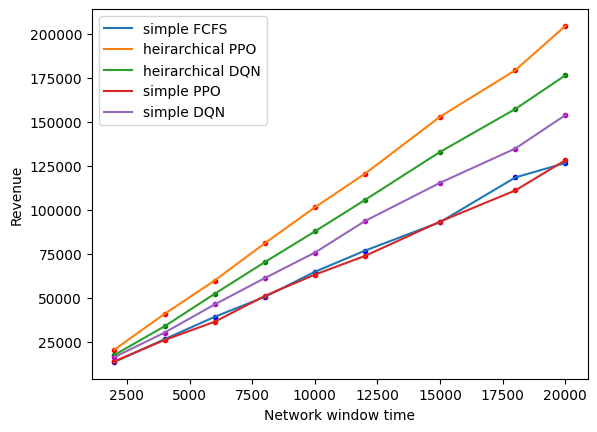

In [195]:
import matplotlib.pyplot as plt
  
# create data
x_nw = [ 2000, 4000, 6000, 8000, 10000, 12000, 15000, 18000, 20000]
y_simple = algo_revenues['simple']
y_h_PPO = algo_revenues['heirar_PPO']
y_h_DQN = algo_revenues['heirar_DQN']
y_s_PPO = algo_revenues['simple_PPO']
y_s_DQN = algo_revenues['simple_DQN']
  
# plot lines
plt.plot(x_nw, y_simple, label = "simple FCFS", linestyle="-")
plt.scatter(x_nw, y_simple, marker='.', color='b')
plt.plot(x_nw, y_h_PPO, label = "heirarchical PPO", linestyle="-")
plt.scatter(x_nw, y_h_PPO, marker='.', color='r')
plt.plot(x_nw, y_h_DQN, label = "heirarchical DQN", linestyle="-")
plt.scatter(x_nw, y_h_DQN, marker='.', color='g')
plt.plot(x_nw, y_s_PPO, label = "simple PPO", linestyle="-")
plt.scatter(x_nw, y_s_PPO, marker='.', color='r')
plt.plot(x_nw, y_s_DQN, label = "simple DQN", linestyle="-")
plt.scatter(x_nw, y_s_DQN, marker='.', color='m')

plt.xlabel("Network window time")
plt.ylabel("Revenue")
plt.legend()
plt.show()